In [1]:
from d2l import tensorflow as d2l
import tensorflow as tf

import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config Completer.use_jedi = False

features = np.array([[0,0],[0,1],[1,0],[1,1]], "float32")
labels   = np.array([0,1,1,0], "float32")

In [2]:
# Esta funcion crea una permutación y parte los datos en bloques

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    index = list(range(num_examples))
    # Las observaciones se leen en orden aleatorio
    random.shuffle(index)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(index[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [3]:
batch_size = 4

train_iter = data_iter(batch_size, features, labels)
test_iter  = data_iter(batch_size, features, labels)

for X, y in train_iter:
    print(X, '\n\n', y)

tf.Tensor(
[[0. 0.]
 [1. 1.]
 [1. 0.]
 [0. 1.]], shape=(4, 2), dtype=float32) 

 tf.Tensor([0. 0. 1. 1.], shape=(4,), dtype=float32)


In [4]:
def train_procedure(net, features, labels, batch_size, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.25],
                        legend=['train loss', 'train acc', 'test acc'], 
                        figsize = [12, 4])
    # Durante cada epoca utilizamos descenso en gradiente para minimizar la perdida
    # y evalua en el conjunto de prueba las capacidades predictivas del modelo
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, 
                                            data_iter(batch_size, features, labels), 
                                            loss, 
                                            updater)
        test_acc = d2l.evaluate_accuracy(net, 
                                         data_iter(batch_size, features, labels))
        animator.add(epoch + 1, train_metrics)
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [25]:
lr = 1.0
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)

In [26]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2, # Capa intermedia (oculta) -> h
                          activation='relu', 
                          kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 100)),
    tf.keras.layers.Dense(2, # Capa de salida           -> o
                          kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 200))])

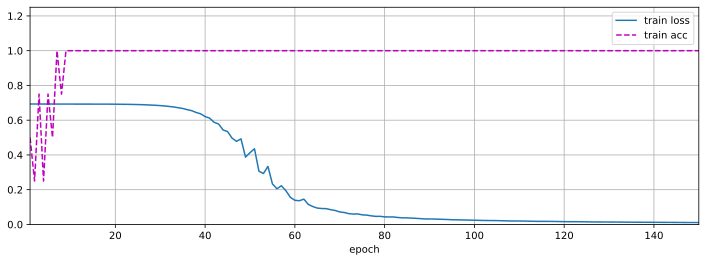

In [27]:
num_epochs = 150
train_procedure(net, features, labels, batch_size, loss, num_epochs, trainer)

In [28]:
# Verificamos la predicción. Ojo: son predicciones en logits. 
net(features)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 2.0616286, -2.061628 ],
       [-2.6460207,  2.6485236],
       [-2.6447036,  2.6013534],
       [ 2.0616286, -2.061628 ]], dtype=float32)>

In [29]:
# Necesitamos softmax para poder hacer predicciones como probabilidades
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

# De una vez definimos la función de activación para analisis posterior
def relu(X):
    return tf.math.maximum(X, 0)

In [30]:
# Definimos una rejilla en el [0,1] \times [0,1] para evaluar el MLP 
# y poder graficar.

n_grid = 100
X1, X2 = np.meshgrid(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid))

# Concatena para tener una matrix de N \times 2
X_ = np.hstack([X1.reshape(-1,1), X2.reshape(-1,1)]).reshape(-1,2)
Z = net(X_)

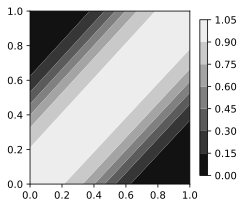

In [31]:
# Gráfico la función de predicción en [0,1] \times [0,1]
fig, ax = plt.subplots(1,1, figsize = [3.5, 3])

cs = ax.contourf(X1, X2, softmax(Z)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
fig.colorbar(cs, ax=ax, shrink=0.9)
plt.tight_layout()

In [32]:
# Extraemos los parametros que conectan capa de entrada con capa intermedia

W1 = net.trainable_variables[0].numpy()
b1 = net.trainable_variables[1].numpy()

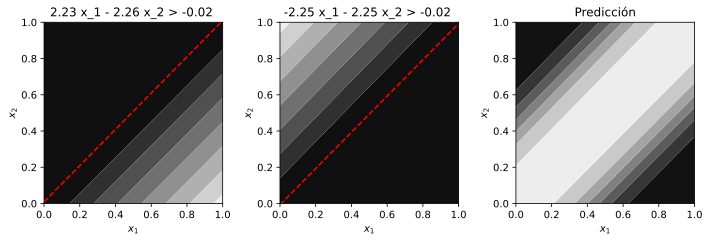

In [34]:
fig, axes = plt.subplots(1,3, figsize = [10, 3.5])

H = relu(X_.dot(net.trainable_variables[0].numpy()) + net.trainable_variables[1].numpy()).numpy()

# Grafica la "decision" de la primera unidad en la primera capa
axes[0].contourf(X1, X2, H[:,0].reshape(n_grid, -1), cmap = 'gray')
axes[0].set_title("%2.2f x_1 - %2.2f x_2 > %2.2f "%(W1[0][0],abs(W1[0][1]), b1[0]) )
axes[0].plot(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid) + b1[0]/W1[0][1], color = 'red', linestyle = 'dashed')

# Grafica la "decision" de la segunda unidad en la primera capa
axes[1].contourf(X1, X2, H[:,1].reshape(n_grid, -1), cmap = 'gray')
axes[1].set_title("%2.2f x_1 - %2.2f x_2 > %2.2f "%(W1[1][0],abs(W1[1][1]), b1[1]) )
axes[1].plot(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid) + b1[1]/W1[1][1], color = 'red', linestyle = 'dashed')

# Grafica la predicción como probabilidades
axes[-1].contourf(X1, X2, softmax(Z)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
axes[-1].set_title("Predicción");

# Itera sobre los elementos de la figura para cambiar limites de cuadros y 
# poner etiquetas lindas en los ejes
for ax in axes:
    ax.set_ylim(0,1); 
    ax.set_xlim(0,1); 
    ax.set_ylabel("$x_2$")
    ax.set_xlabel("$x_1$")
    
    
fig.tight_layout()

In [37]:
# Extraemos los parametros que conectan capa intermedia con capa de salida
W2 = net.trainable_variables[2].numpy()
b2 =net.trainable_variables[3].numpy()

# Definimos una rejilla para evaluar la salida de la capa oculta y ver la "decision" 
# en el flujo
H1, H2 = np.meshgrid(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid))
H_ = np.hstack([H1.reshape(-1,1), H2.reshape(-1,1)]).reshape(-1,2)

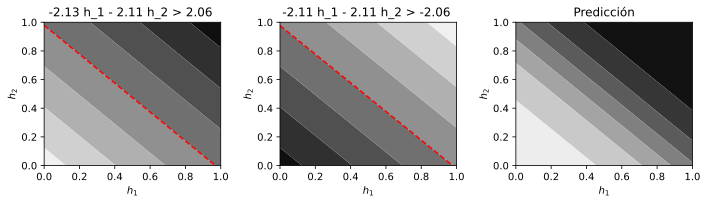

In [38]:
fig, axes = plt.subplots(1,3, figsize = [10, 3])

OH = H_.dot(net.trainable_variables[2].numpy()) + net.trainable_variables[3].numpy()

# Graficamos la decision de la capa de salida (primera unidad) en el espacio de h
axes[0].contourf(X1, X2, OH[:,0].reshape(n_grid, -1), cmap = 'gray')
axes[0].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[0][0],abs(W2[0][1]), b2[0]) )
axes[0].set_xlabel("$h_1$"); axes[0].set_ylabel("$h_2$")
axes[0].plot(np.linspace(0,1,n_grid), W2[0][0]/W2[0][1] * np.linspace(0,1,n_grid) + b2[0]/W2[0][1], color = 'red', linestyle = 'dashed')

# Graficamos la decision de la capa de salida (segunda unidad) en el espacio de h
axes[1].contourf(X1, X2, OH[:,1].reshape(n_grid, -1), cmap = 'gray')
axes[1].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[1][0],abs(W2[1][1]), b2[1]) )
axes[1].set_xlabel("$h_1$"); axes[1].set_ylabel("$h_2$");
axes[1].plot(np.linspace(0,1,n_grid), W2[1][0]/W2[1][1] * np.linspace(0,1,n_grid) - b2[1]/W2[1][1], color = 'red', linestyle = 'dashed')

# Graficamos prediccion como función del espacio h
axes[-1].contourf(X1, X2, softmax(OH)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
axes[-1].set_title("Predicción");
axes[-1].set_xlabel("$h_1$"); axes[-1].set_ylabel("$h_2$"); 

# Itera sobre los elementos de la figura para definir limites
for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)

fig.tight_layout()

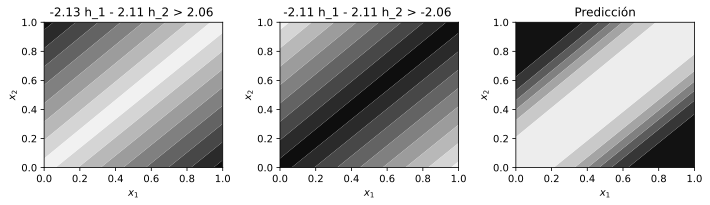

In [40]:
fig, axes = plt.subplots(1,3, figsize = [10, 3])

O = H.dot(net.trainable_variables[2].numpy()) + net.trainable_variables[3].numpy()

# Graficamos la decision de la capa de salida (primera unidad) en el espacio de x
axes[0].contourf(X1, X2, O[:,0].reshape(n_grid, -1), cmap = 'gray')
axes[0].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[0][0],abs(W2[0][1]), b2[0]) )
axes[0].set_xlabel("$x_1$"); axes[0].set_ylabel("$x_2$")

# Graficamos la decision de la capa de salida (segunda unidad) en el espacio de x
axes[1].contourf(X1, X2, O[:,1].reshape(n_grid, -1), cmap = 'gray')
axes[1].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[1][0],abs(W2[1][1]), b2[1]) )
axes[1].set_xlabel("$x_1$"); axes[1].set_ylabel("$x_2$");

# Graficamos prediccion en el espacio de x
axes[-1].contourf(X1, X2, softmax(Z)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
axes[-1].set_title("Predicción");
axes[-1].set_xlabel("$x_1$"); axes[-1].set_ylabel("$x_2$"); 

for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)

fig.tight_layout()

# Ejercicios

1. Intenta utilizar una función de activación sigmoide para la capa intermedia. Tendrás que cambiar el parámetro de aprendizaje `lr` (intenta con 1, 5, 8, 10) ¿Qué observas? ¿A qué crees que se deba este comportamiento?
1. Modifica la solución de arriba para que sólo tenga una unidad en la capa de salida. 


# Solucion fácil y aburrida :P 

In [ ]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
net.compile(loss='binary_crossentropy',
            optimizer='sgd', 
            metrics=['binary_accuracy'])

In [ ]:
net.fit(features, labels, verbose = 2, epochs=200)